In [116]:
#Setting up prerequisites
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

from cvxpy import *
from numpy import matrix

print("Setup Complete\n")

Setup Complete



In [117]:
df1 = pd.read_csv('netflix-prize-data/toy_combined_data.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols = [0,1,2])
df1['Rating'] = df1['Rating'].astype(float)
df1['Date'] = df1['Date'].astype(str)
df1['Date'] = df1['Date'].map( lambda s : (s[:4])+(s[5:7])+(s[8:]))
df1['Date'] = df1['Date'].astype(float)
print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::100, :])
print(df1['Date'].dtype)
df = df1

Dataset 1 shape: (1024, 3)
-Dataset examples-
      Cust_Id  Rating        Date
0          1:     NaN         NaN
100   2630337     5.0  20050310.0
200    573434     4.0  20040526.0
300    638824     5.0  20040519.0
400   1653834     4.0  20040822.0
500   1033930     3.0  20050811.0
600    349407     5.0  20050102.0
700    656399     4.0  20030920.0
800   1456369     4.0  20030708.0
900    253037     3.0  20050805.0
1000  1369550     3.0  20041011.0
float64


See Overview of the Data


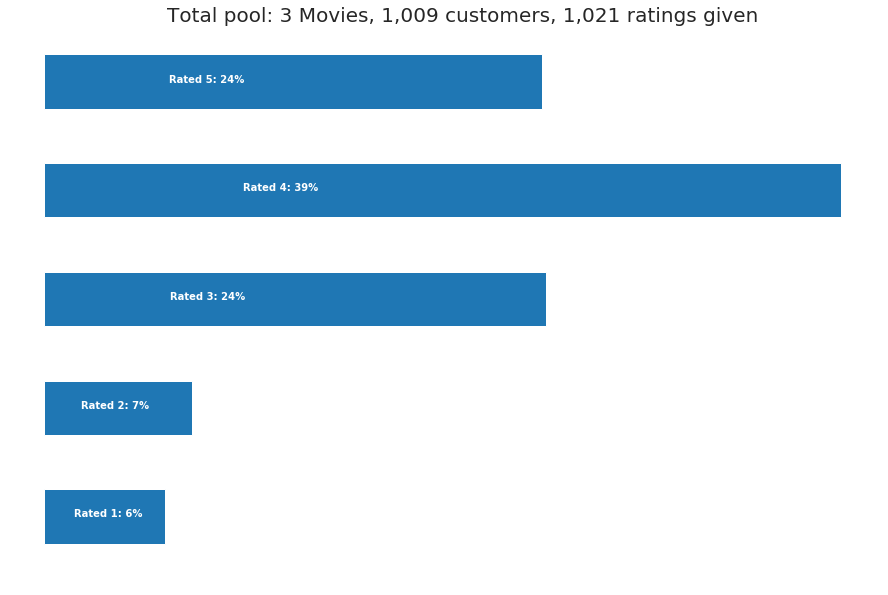

In [118]:
#Seeing the distribution of ratings given by the users
print("See Overview of the Data")
p = df.groupby('Rating')['Rating'].agg(['count'])
# get movie count
movie_count = df.isnull().sum()[1]
# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count
# get rating count
rating_count = df['Cust_Id'].count() - movie_count
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rated {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [119]:
#Adding movie IDs to the dataset
movie_np = []
movie_id = 0
for x in range(df.shape[0]):
    if(np.isnan(df.iloc[x]['Rating'])):
        movie_id = movie_id+1
    movie_np = np.append(movie_np,movie_id)

#print(movie_np)
#print(len(movie_np))
df['Movie_Id'] = movie_np.astype(int)
print("Movie IDs extracted from the extra rows given")

Movie IDs extracted from the extra rows given


In [120]:
# remove the extra Movie ID rows
df = df[pd.notnull(df['Rating'])]
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::100, :])


print("\n\nThese are the final datatypes of the dataset")
print(df.dtypes)

-Dataset examples-
      Cust_Id  Rating        Date  Movie_Id
1     1488844     3.0  20050906.0         1
101   1155747     3.0  20050703.0         1
201   1141189     4.0  20041215.0         1
301   2256485     1.0  20040819.0         1
401   2322840     3.0  20050712.0         1
501     45117     5.0  20050815.0         1
602   2596999     4.0  20051007.0         2
703   1644750     3.0  20030319.0         3
803    372528     3.0  20040630.0         3
903   1115632     3.0  20031124.0         3
1003  2085230     4.0  20040315.0         3


These are the final datatypes of the dataset
Cust_Id       int64
Rating      float64
Date        float64
Movie_Id      int64
dtype: object


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
#Creating Data Matrix
df_matrix=pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_matrix.shape)

(1009, 3)


In [122]:
#Loading the Movie ID- Movie Title Mapping File

df_title = pd.read_csv('netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print("See some Movie ID- Movie Title Mapping : \n")
print (df_title.head(8))

See some Movie ID- Movie Title Mapping : 

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?


In [123]:
print("\n\nData Cleaning Complete.\n See head of the Data Matrix:\n")
print(df_matrix.head())

n_movies = movie_count
n_customers = cust_count

print("\nNum of movies =", movie_count)
print("Num of users =", cust_count)



Data Cleaning Complete.
 See head of the Data Matrix:

Movie_Id    1   2    3
Cust_Id               
915       5.0 NaN  NaN
1333      NaN NaN  4.0
2442      3.0 NaN  NaN
3321      3.0 NaN  NaN
4326      4.0 NaN  NaN

Num of movies = 3
Num of users = 1009


In [124]:
#Choosing the number of latent attributes
n_attr= 100*1000000
#print(type(n_attr),type(n_movies), type(n_customers))
Q = Variable((n_attr,n_movies))
P = Variable((n_attr, n_customers))



acq_data = df_matrix.fillna(0.0)
print(acq_data.head())



Movie_Id    1    2    3
Cust_Id                
915       5.0  0.0  0.0
1333      0.0  0.0  4.0
2442      3.0  0.0  0.0
3321      3.0  0.0  0.0
4326      4.0  0.0  0.0


In [125]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            #if (i+1) % 100 == 0:
            #    print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [101]:
#This cell works on Toy Dataset
#The next cell is for real data
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

R1= np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

#Set the number of values to replace. For example 20%:
prop = int(R.size * 0.2)

#Randomly choose indices of the numpy array:
i = [np.random.choice(range(R.shape[0])) for _ in range(prop)]
j = [np.random.choice(range(R.shape[1])) for _ in range(prop)]

#Change values with 0
R[i,j] = 0
print("Original:\n",R1)
print("Test Set:\n",R)
R=np.rint(R)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(R, R1)

print("MSE=",mse**0.5)

print("\nTraining ...\n")


mf = MF(R, K=10000, alpha=0.01, beta=0.01, iterations=10000)
training_process = mf.train()
L=np.rint(mf.full_matrix())



print("Learnt=\n",L)
msef=0.0
for i1 in range(len(i)):
    for i2 in range(len(j)):
        if R1.item(i[i1],j[i2])!=0:
            msef = msef + (R1.item((i[i1],j[i2]))-(L).item((i[i1],j[i2])))**2
msef = (msef/(len(j)*len(i)))
print("RMSE f=",msef**0.5)

Original:
 [[5 3 0 1]
 [4 0 0 1]
 [1 1 0 5]
 [1 0 0 4]
 [0 1 5 4]]
Test Set:
 [[5 3 0 1]
 [4 0 0 1]
 [1 1 0 5]
 [0 0 0 4]
 [0 1 5 0]]
MSE= 0.9219544457292888

Training ...

Learnt=
 [[5. 3. 3. 1.]
 [4. 2. 3. 1.]
 [1. 1. 6. 5.]
 [3. 2. 5. 4.]
 [1. 1. 5. 4.]]
RMSE f= 0.8660254037844386


In [139]:
#This cell works on Real DataSet

R = np.array(acq_data)

R1= np.array(acq_data)

#Set the number of values to replace. For example 20%:
prop = int(R.size * 0.2)

#Randomly choose indices of the numpy array:
i = [np.random.choice(range(R.shape[0])) for _ in range(prop)]
j = [np.random.choice(range(R.shape[1])) for _ in range(prop)]

#Change values with 0
R[i,j] = 0
print("Original:\n",R1)
print("Test Set:\n",R)
R=np.rint(R)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(R, R1)

print("MSE=",mse**0.5)

print("\nTraining ...\n")


mf = MF(R, K=10000, alpha=0.01, beta=0.01, iterations=100)
training_process = mf.train()
L=np.rint(mf.full_matrix())

print("\nDone\n")

Original:
 [[5. 0. 0.]
 [0. 0. 4.]
 [3. 0. 0.]
 ...
 [0. 0. 3.]
 [4. 0. 0.]
 [0. 3. 0.]]
Test Set:
 [[5. 0. 0.]
 [0. 0. 4.]
 [3. 0. 0.]
 ...
 [0. 0. 3.]
 [4. 0. 0.]
 [0. 3. 0.]]
MSE= 0.9522806592149013

Training ...


Done



Minimizing Error on Training Set:



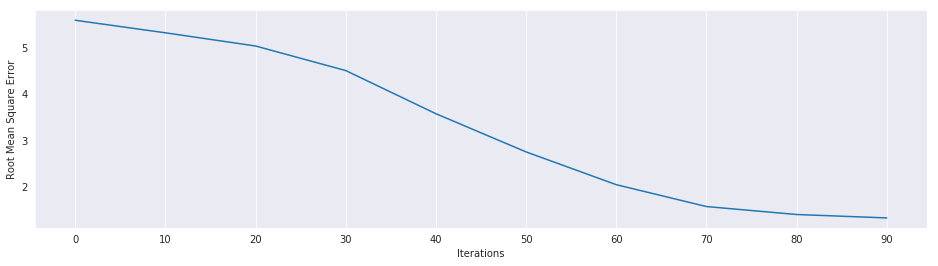

In [138]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
x = x[::10]
y = y[::10]
plt.figure(figsize=((16,4)))
plt.plot(x, np.sqrt(y))
plt.xticks(x, x)

print("Minimizing Error on Training Set:\n")
plt.xlabel("Iterations")
plt.ylabel("Root Mean Square Error")
plt.grid(axis="y")

In [135]:
print("Learnt=\n",mf.full_matrix())
print("\nRating predictions=\n",L)

print()
print("P x Q:")
print(mf.full_matrix())
print()
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)

print("\nFinding Error on test set...\n")
msef=0.0
for i1 in range(len(i)):
    for i2 in range(len(j)):
        if R1.item(i[i1],j[i2])!=0:
            msef = msef + (R1.item((i[i1],j[i2]))-(L).item((i[i1],j[i2])))**2
msef = (msef/(len(j)*len(i)))
print("RMSE f=",msef**0.5)

Learnt=
 [[4.92519455 4.45237587 4.03105201]
 [3.92656424 3.75922101 3.97495875]
 [3.03875459 3.06278695 3.34900645]
 ...
 [3.76684225 3.59991078 3.61421131]
 [3.76735095 3.6001197  3.61418442]
 [3.33974773 3.02411301 3.35034179]]

Rating predictions=
 [[5. 4. 4.]
 [4. 4. 4.]
 [3. 3. 3.]
 ...
 [4. 4. 4.]
 [4. 4. 4.]
 [3. 3. 3.]]

P x Q:
[[4.92519455 4.45237587 4.03105201]
 [3.92656424 3.75922101 3.97495875]
 [3.03875459 3.06278695 3.34900645]
 ...
 [3.76684225 3.59991078 3.61421131]
 [3.76735095 3.6001197  3.61418442]
 [3.33974773 3.02411301 3.35034179]]

Global bias:
3.688861985472155

User bias:
[ 0.42868902  0.16245438 -0.27258023 ...  0.          0.
 -0.2687577 ]

Item bias:
[ 0.07818754 -0.08891514 -0.07470079]

Finding Error on test set...

RMSE f= 0.46105629990963165
